<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Sentiment_analysis_with_Hugging_face_and_BERT_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

from transformers import (GPT2Config, GPT2LMHeadModel, GPT2DoubleHeadsModel,
                                  AdamW, get_linear_schedule_with_warmup) 


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import get_linear_schedule_with_warmup
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("/content/APPLE_iPhone_SE.csv")
df.head()

,Ratings,Comment,Reviews
0,5,Super!,Great camera for pics and videos Battery life ...
1,5,Must buy!,Great device. Let me tell the Pros..1. Superb ...
2,5,Great product,"Who all loves older size i.e., 4.7 inch type s..."
3,5,Simply awesome,This iPhone SE is the best phone ever you get....
4,5,Classy product,This is my second iphone after iphone 4s. I’ve...


In [9]:
df.shape

(9713, 3)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9713 entries, 0 to 9712
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Ratings  9713 non-null   int64 
 1   Comment  9713 non-null   object
 2   Reviews  9713 non-null   object
dtypes: int64(1), object(2)
memory usage: 227.8+ KB


Text(0.5, 0, 'review rating')

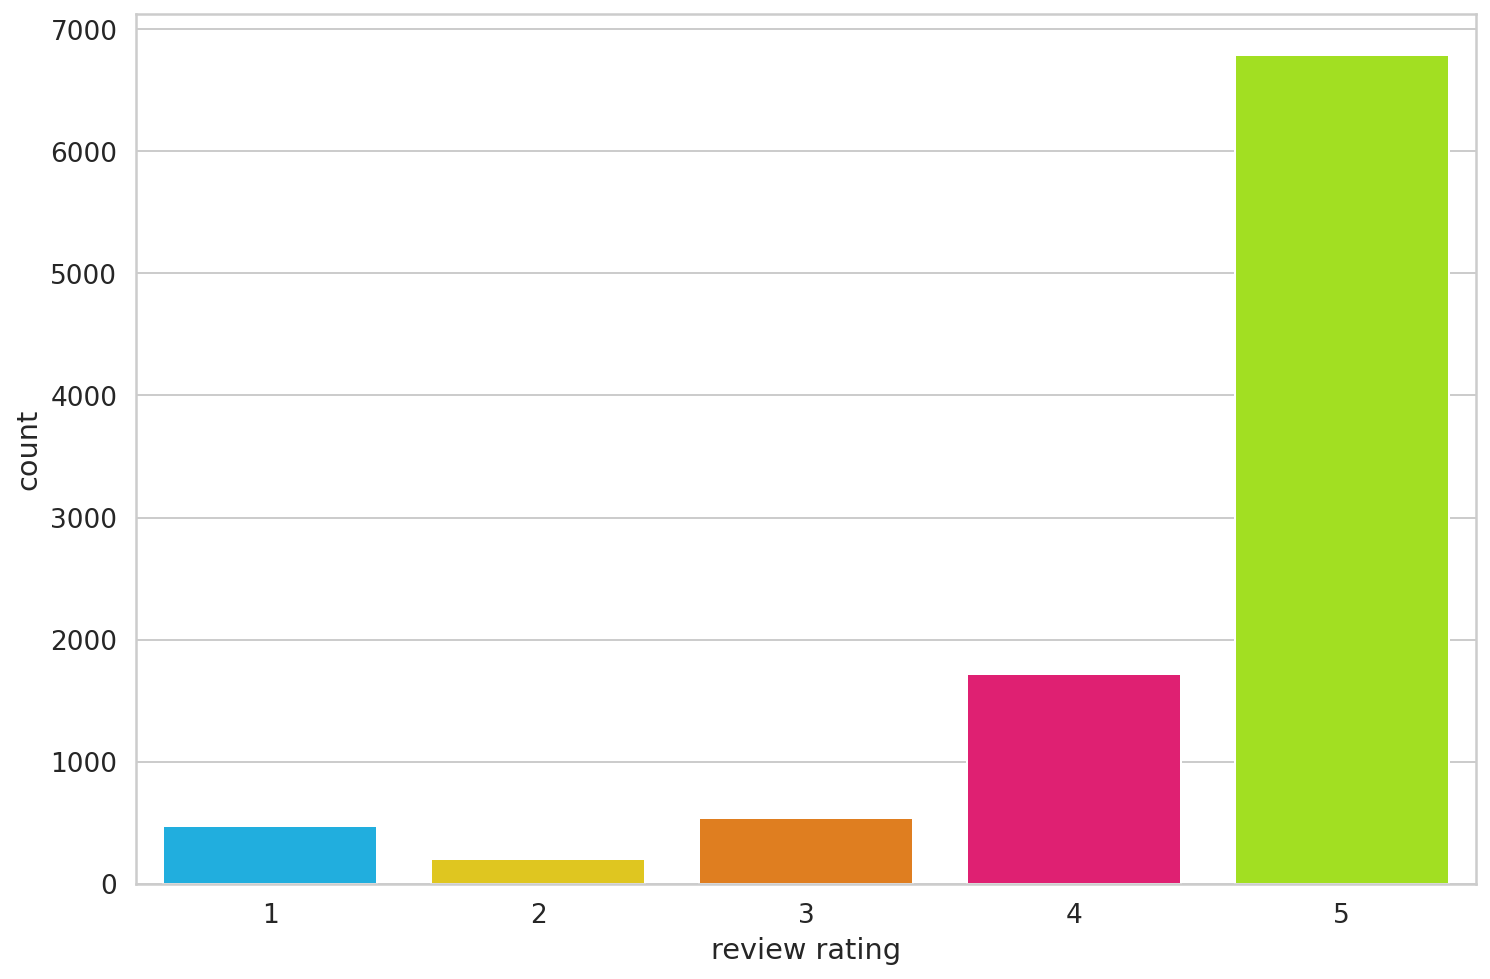

In [11]:
sns.countplot(df.Ratings)
plt.xlabel('review rating')

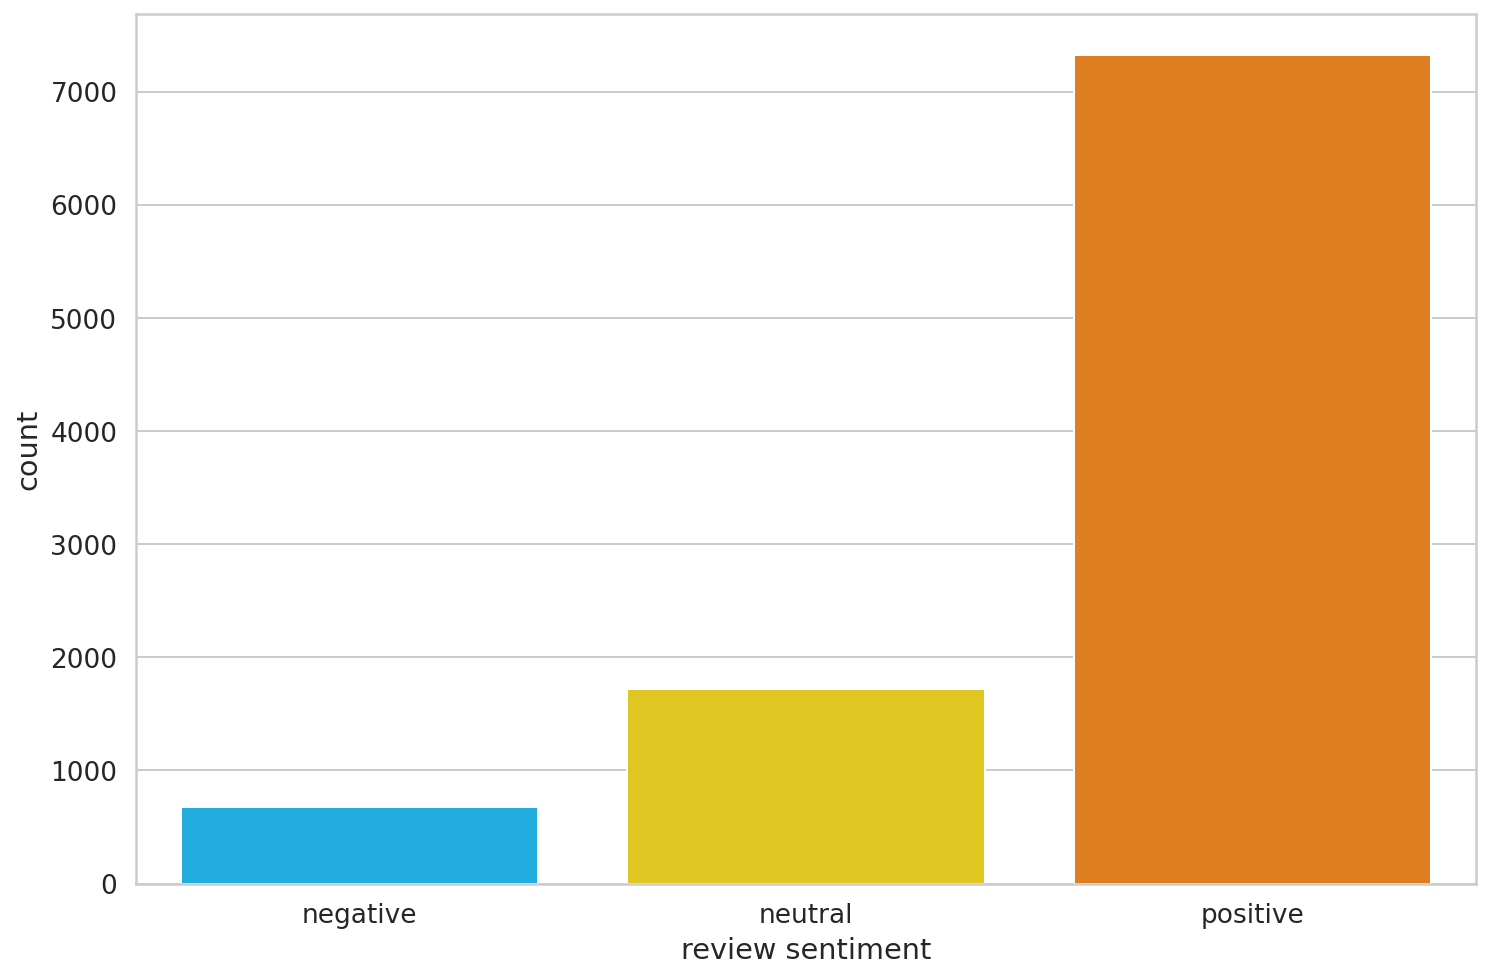

In [12]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2



df['sentiment'] = df.Ratings.apply(to_sentiment)

class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

Data Preprocessing

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
token_lens = []

for txt in df.Reviews:
  tokens = tokenizer.encode(txt, max_length = 512, truncation=True)
  token_lens.append(len(tokens))

and plot the distribution

Text(0.5, 0, 'Token count')

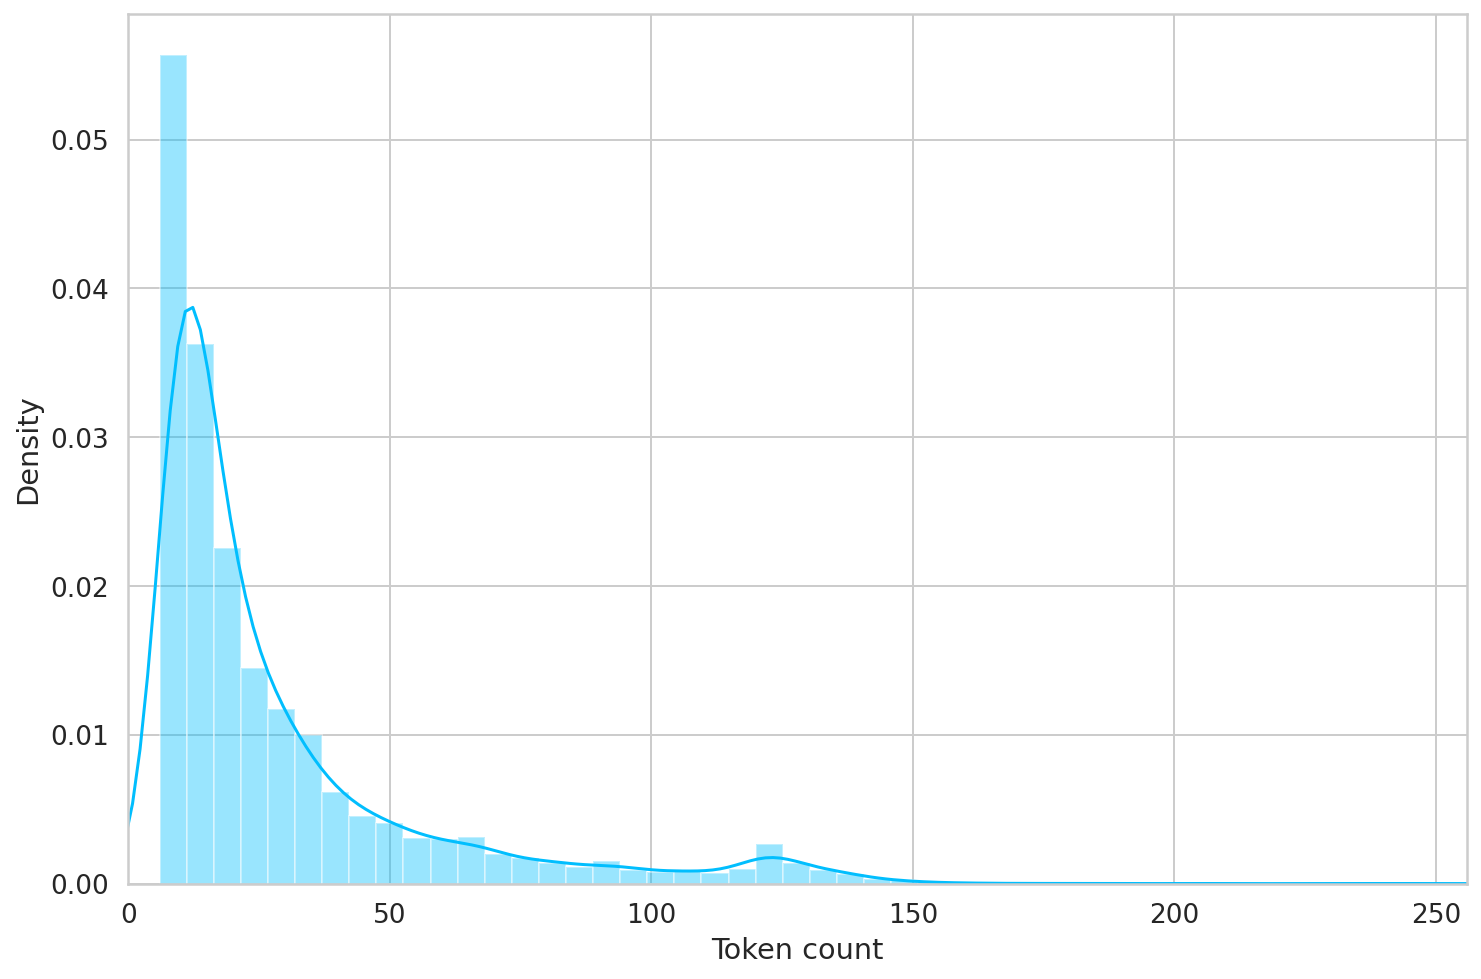

In [17]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 150

In [18]:
MAX_LEN = 150

Create a dataset

In [19]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len


  def __len__(self):
    return len(self.reviews)



  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        review, 
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt',
        truncation = True

    ) 
    return {
        'reviews_text' : review,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(target, dtype = torch.long)
    }   

Split the data

In [20]:
df_train, df_test = train_test_split(
    df,
    test_size = 0.1,
    random_state = RANDOM_SEED
)

df_val, df_test = train_test_split(
    df_test,
    test_size = 0.5,
    random_state = RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((8741, 4), (486, 4), (486, 4))

create of data loader

In [21]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      reviews = df.Reviews.to_numpy(),
      targets = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return DataLoader(
      ds, 
      batch_size = batch_size,
      num_workers = 4
  )

  
  
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)




an example batch from our training data loader

In [22]:

data = next(iter(train_data_loader))
data.keys()

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 145])
torch.Size([16, 145])
torch.Size([16])

torch.Size([32, 150])
torch.Size([32, 150])
torch.Size([32])


torch.Size([16])

In [24]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p=0.3)
    
    
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)


  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = input_ids, 
        attention_mask = attention_mask, return_dict=False 
    )  

    output = self.drop(pooled_output)

    return self.out(output)


In [25]:
from transformers import logging

logging.set_verbosity_warning()

In [26]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


create a GPU

In [27]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [29]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([32, 150])
torch.Size([32, 150])


Softmax function

In [30]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2231, 0.4751, 0.3018],
        [0.2339, 0.3641, 0.4020],
        [0.3052, 0.3037, 0.3912],
        [0.2164, 0.3866, 0.3971],
        [0.5627, 0.2507, 0.1866],
        [0.2250, 0.4630, 0.3120],
        [0.2627, 0.3467, 0.3907],
        [0.3670, 0.2542, 0.3789],
        [0.3913, 0.2049, 0.4038],
        [0.3517, 0.1869, 0.4613],
        [0.3383, 0.2151, 0.4467],
        [0.3416, 0.2198, 0.4386],
        [0.2221, 0.4177, 0.3602],
        [0.2799, 0.3210, 0.3991],
        [0.3268, 0.2645, 0.4087],
        [0.1544, 0.3972, 0.4484],
        [0.1901, 0.2806, 0.5294],
        [0.2601, 0.3139, 0.4260],
        [0.2273, 0.4034, 0.3693],
        [0.4346, 0.2152, 0.3501],
        [0.3621, 0.2409, 0.3970],
        [0.4134, 0.2554, 0.3312],
        [0.4006, 0.2780, 0.3214],
        [0.1760, 0.3930, 0.4310],
        [0.2423, 0.3688, 0.3889],
        [0.2125, 0.4171, 0.3704],
        [0.3032, 0.3854, 0.3114],
        [0.3460, 0.3746, 0.2795],
        [0.4973, 0.1875, 0.3151],
        [0.271

In [31]:
model.parameters

<bound method Module.parameters of SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

Use loss function as Cross Entropy

In [32]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias = False)
total_steps = len(train_data_loader)*EPOCHS



scheduler = get_linear_schedule_with_warmup(

  optimizer,

  num_warmup_steps=0,

  num_training_steps=total_steps

)


loss_fn = nn.CrossEntropyLoss().to(device)

Helper function for training

In [33]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )

    _, preds = torch.max(outputs, dim = 1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)

    

    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

   
  return correct_predictions.double() / n_examples, np.mean(losses) 

evaluate model

In [34]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []

  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      targets = d["targets"].to(device)

      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _, preds = torch.max(outputs, dim = 1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      

      losses.append(loss.item())

    return correct_predictions.double()/n_examples, np.mean(losses)  

    



the training history

In [35]:
from collections import defaultdict

In [36]:
import logging
logging.basicConfig(level=logging.ERROR)

In [37]:


%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1} / {EPOCHS}')
  print('_' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader, 
      loss_fn,
      optimizer, 
      device,
      scheduler,
      len(df_train)

  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)


  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1 / 5
__________
Train loss 0.6033924261148829 accuracy 0.7643290241391145
Val   loss 0.5490640327334404 accuracy 0.7818930041152264

Epoch 2 / 5
__________
Train loss 0.5082206985484945 accuracy 0.7919002402471114
Val   loss 0.5473469104617834 accuracy 0.7695473251028807

Epoch 3 / 5
__________
Train loss 0.43948910825879034 accuracy 0.8176410021736644
Val   loss 0.5843373537063599 accuracy 0.7551440329218108

Epoch 4 / 5
__________
Train loss 0.37154244987742746 accuracy 0.8566525569156848
Val   loss 0.6698097791522741 accuracy 0.7469135802469137

Epoch 5 / 5
__________
Train loss 0.3204161077737808 accuracy 0.8806772680471342
Val   loss 0.7108045257627964 accuracy 0.7427983539094651

CPU times: user 33min 27s, sys: 16.3 s, total: 33min 44s
Wall time: 33min 52s
